In [1]:
from firedrake import (
    RectangleMesh,
    FunctionSpace,
    Function,
    SpatialCoordinate,
    conditional,
    File,
)

In [2]:
from firedrake import *
import spyro
import numpy as np
import math
import numpy                  as np
import matplotlib.pyplot      as plot
import matplotlib.ticker      as mticker  
from matplotlib               import cm, ticker
from mpl_toolkits.axes_grid1  import make_axes_locatable

In [3]:
model = {}
model["opts"] = {
    "method": "KMV",  # either CG or KMV
    "quadratrue": "KMV",  # Equi or KMV
    "degree": 2,  # p order
    "dimension": 2,  # dimension
}
model["parallelism"] = {
    "type": "spatial",  # options: automatic (same number of cores for evey processor), custom, off.
    "custom_cores_per_shot": [],  # only if the user wants a different number of cores for every shot.
    "num_cores_per_shot": 1
}
model["mesh"] = {
    "Lz": 1.,  # depth in km - always positive
    "Lx": 1.,  # width in km - always positive
    "Ly": 0.0,  # thickness in km - always positive
    "meshfile": "meshes/square.msh",
    "initmodel": "not_used.hdf5",
    "truemodel": "velocity_models/MarmousiII_w1KM_EXT_GUESS.hdf5",
}
model["BCs"] = {
    "status": False,  # True or false
    "outer_bc": "None",  #  None or non-reflective (outer boundary condition)
    "damping_type": "polynomial",  # polynomial, hyperbolic, shifted_hyperbolic
    "exponent": 2,  # damping layer has a exponent variation
    "cmax": 4.5,  # maximum acoustic wave velocity in PML - km/s
    "R": 1e-6,  # theoretical reflection coefficient
    "lz": 0.9,  # thickness of the PML in the z-direction (km) - always positive
    "lx": 0.9,  # thickness of the PML in the x-direction (km) - always positive
    "ly": 0.0,  # thickness of the PML in the y-direction (km) - always positive
}
model["acquisition"] = {
    "source_type": "Ricker",
    "num_sources": 2,
    "source_pos": spyro.create_transect((-0.1, 0.1), (-0.1, 0.9), 2),
    "frequency": 4.0,
    "delay": 1.0,
    "num_receivers": 100,
    "receiver_locations": spyro.create_transect((-0.10, 0.1), (-0.10, 0.9), 100),
}
model["timeaxis"] = {
    "t0": 0.0,  #  Initial time for event
    "tf": 1.00,  # Final time for event
    "dt": 0.001,
    "amplitude": 1,  # the Ricker has an amplitude of 1.
    "nspool": 100,  # how frequently to output solution to pvds
    "fspool": 99999,  # how frequently to save solution to RAM
}

In [4]:
comm    = spyro.utils.mpi_init(model)
mesh, V = spyro.io.read_mesh(model, comm)

x, y = SpatialCoordinate(mesh)
velocity = conditional(x > -0.5, 1.5, 1.5)
vp   = Function(V, name="vp").interpolate(velocity)


INFO: Distributing 2 shot(s) across 1 core(s). Each shot is using 1 cores
  rank 0 on ensemble 0 owns 780 elements and can access 431 vertices


In [5]:
sources = spyro.Sources(model, mesh, V, comm)
tf   = model["timeaxis"]["tf"] 
dt   = model["timeaxis"]["dt"]
freq = model["acquisition"]["frequency"]
receivers = spyro.Receivers(model, mesh, V, comm)
wavelet = spyro.full_ricker_wavelet(dt=dt, tf=tf, freq=freq)



In [6]:
solver         = spyro.solvers.forward

usol_rec = []
dJdm = Function(V)
J_total =0
for sn in range(0,model["acquisition"]["num_sources"]):
    usol, p_rec  = solver(model, mesh, comm, vp, sources, wavelet, receivers, source_num=sn)    
    
    p_true_rec   = spyro.io.load_shots(model, comm, file_name='true_rec/true_rec_' + str(sn))
    misfit   = spyro.utils.evaluate_misfit(model, p_rec, p_true_rec)
    usol_rec.append(p_rec)
    J = spyro.utils.compute_functional(model,misfit)
    print(J)
    J_total += J
    dJdm    += spyro.solvers.gradient(model,mesh,comm,vp, receivers,usol,misfit)


Simulation time is:      0.099 seconds
Simulation time is:      0.199 seconds
Simulation time is:      0.299 seconds
Simulation time is:      0.399 seconds
Simulation time is:      0.499 seconds
Simulation time is:      0.599 seconds
Simulation time is:      0.699 seconds
Simulation time is:      0.799 seconds
Simulation time is:      0.899 seconds
1.6591266033514187e-06
Simulation time is:        0.9 seconds
Simulation time is:        0.8 seconds
Simulation time is:        0.7 seconds
Simulation time is:        0.6 seconds
Simulation time is:        0.5 seconds
Simulation time is:        0.4 seconds
Simulation time is:        0.3 seconds
Simulation time is:        0.2 seconds
Simulation time is:        0.1 seconds
Simulation time is:        0.0 seconds
Simulation time is:      0.099 seconds
Simulation time is:      0.199 seconds
Simulation time is:      0.299 seconds
Simulation time is:      0.399 seconds
Simulation time is:      0.499 seconds
Simulation time is:      0.599 seconds
Si

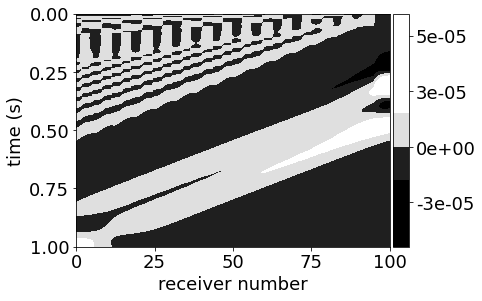

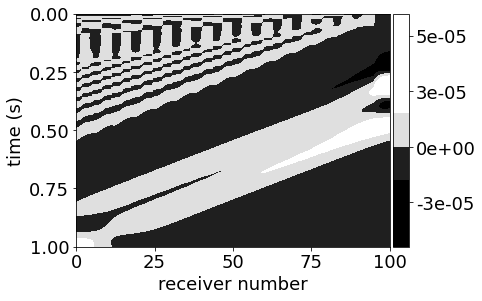

In [7]:
spyro.plots.plot_shots(
            model,comm,usol_rec[1],show=True,file_name=str(0 + 1),legend=True,save=False
        )

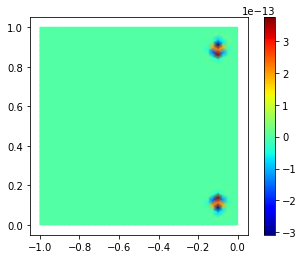

In [8]:
from mpi4py import MPI

dJdm.dat.data[:] = comm.ensemble_comm.allreduce(
    dJdm.dat.data[:], op=MPI.SUM
)


fig, axes = plot.subplots()
axes.set_aspect('equal')
colors = firedrake.tripcolor(dJdm, axes=axes, shading='gouraud', cmap="jet")

fig.colorbar(colors);
plot.savefig('grad.png',dpi=100,format='png')

In [9]:
File("vel.pvd").write(vp)